#### Functions (IGNORE)

In [5]:
# import packages that will be used for analysis
import random
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

##### Get Stock Data

In [6]:
import yfinance as yf
missing_data_tickers = [] # use this as a list of tickers with missing data

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [7]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [8]:
import pandas as pd

# Get the adjusted close prices
adj_close_sector_etf = {}

# Create adjusted close price only listing of sector ETFs
def get_adjusted_closed_price(nested_dict, tickers, periods):
    for period in periods:
        stock_price_df = pd.DataFrame()  # Create a new DataFrame for each period
        for ticker in tickers:
            stock_price_df[ticker] = nested_dict[period][ticker]['Adj Close']
        
        adj_close_sector_etf[period] = stock_price_df  # Store the complete DataFrame for the period
    
    return adj_close_sector_etf

##### Ichimoku Cloud

In [16]:
def ichimoku_components(nested_dict, periods, tickers):
    for period in periods:
        for ticker in tickers:
            # Create parameters
            df_ticker = nested_dict[period][ticker]

            # Create conversion line
            hi_val = df_ticker['High'].rolling(window=9).max()
            low_val = df_ticker['Low'].rolling(window=9).min()
            df_ticker['Conversion'] = (hi_val + low_val) / 2

            # Create baseline
            hi_val2 = df_ticker['High'].rolling(window=26).max()
            low_val2 = df_ticker['Low'].rolling(window=26).min()
            df_ticker['Baseline'] = (hi_val2 + low_val2) / 2

            # Create Leading Span A (Senkou Span A)
            df_ticker['Leading Span A'] = ((df_ticker['Conversion'] + df_ticker['Baseline']) / 2).shift(26)

            # Create Leading Span B (Senkou Span B)
            hi_val3 = df_ticker['High'].rolling(window=52).max()
            low_val3 = df_ticker['Low'].rolling(window=52).min()
            df_ticker['Leading Span B'] = ((hi_val3 + low_val3) / 2).shift(26)

            # Create Lagging Span (Chikou Span)
            df_ticker['Lagging Span'] = df_ticker['Close'].shift(-26)

    return nested_dict

In [23]:
def ichimoku_signal_with_labels(nested_dict, periods, tickers):
    for period in periods:
        for ticker in tickers:
            # Create parameters
            df_ticker = nested_dict[period][ticker]

            # Initialize the Signal column with 'Hold'
            df_ticker['Signal'] = 'Hold'

            # Generate buy signals
            buy_condition = (
                (df_ticker['Conversion'].shift(1) < df_ticker['Baseline'].shift(1)) &
                (df_ticker['Conversion'] > df_ticker['Baseline'])
            )
            
            # Generate sell signals
            sell_condition = (
                (df_ticker['Conversion'].shift(1) > df_ticker['Baseline'].shift(1)) &
                (df_ticker['Conversion'] < df_ticker['Baseline'])
            )
            
            # Assign 'Buy' and 'Sell' based on the conditions
            df_ticker.loc[buy_condition, 'Signal'] = 'Buy'
            df_ticker.loc[sell_condition, 'Signal'] = 'Sell'

    return nested_dict

# Chapter 4: Ichimoku Cloud
The Ichimoku is considered an all in one indicator as it contains information on momentum, support and resistance. It is made up of 5 lines.

- Conversion Line : Represents support, resistance and reversals. Used to measure short term trends
- Baseline : represents support, resistance and confirms trend changes. Allows you to evaluate the strength of medium term trends. Called the baseline because it lags the price 
- Leading span A : used to identify the future areas of support and resistance
- Leading span B : Other line used to identify future support and resistance 
- Lagging span : shows possible support and resistance
- Cloud : space between A and B, represents the divergence in price evolution

In [9]:
# create time periods for where this takes place
economic_cycle_periods = {

    "trough": ("2008-10-01", "2009-06-01"),
    "expansion": ("2012-01-01", "2015-01-01"),
    "peak": ("2019-06-01", "2020-02-01"),
    "contraction": ("2007-12-01", "2008-10-01"),
    'all_data': ('2005-01-01','2024-06-01')
}

economic_cycle_periods_list = ['trough','expansion','peak','contraction','all_data']

In [10]:
# create etf tickers for sectors
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'VOX', # communication services
    'XLU', # utilities
    'IYR' # real estate
    ]

In [11]:
# save nested dictionary data as a variable to be accessed.
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [17]:
ichimoku_components(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

{'trough': {'XLB':                  Open       High        Low      Close  Adj Close    Volume  \
  Date                                                                          
  2008-10-01  32.759998  33.189999  32.130001  32.849998  23.119261  14639500   
  2008-10-02  31.540001  31.860001  29.930000  30.490000  21.458338  12581300   
  2008-10-03  30.190001  31.690001  29.780001  30.190001  21.247202  16770600   
  2008-10-06  29.510000  29.510000  26.889999  28.700001  20.198566  22512700   
  2008-10-07  29.160000  29.530001  27.049999  27.219999  19.156975  16004900   
  ...               ...        ...        ...        ...        ...       ...   
  2009-05-22  26.530001  26.660000  26.110001  26.299999  18.848709   8421500   
  2009-05-26  26.170000  26.969999  25.830000  26.930000  19.300224   7886900   
  2009-05-27  26.790001  26.850000  25.860001  25.920000  18.576378   7216600   
  2009-05-28  26.190001  26.440001  25.760000  26.379999  18.906050   8773400   
  2009-05-2

In [24]:
ichimoku_signal_with_labels(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

{'trough': {'XLB':                  Open       High        Low      Close  Adj Close    Volume  \
  Date                                                                          
  2008-10-01  32.759998  33.189999  32.130001  32.849998  23.119261  14639500   
  2008-10-02  31.540001  31.860001  29.930000  30.490000  21.458338  12581300   
  2008-10-03  30.190001  31.690001  29.780001  30.190001  21.247202  16770600   
  2008-10-06  29.510000  29.510000  26.889999  28.700001  20.198566  22512700   
  2008-10-07  29.160000  29.530001  27.049999  27.219999  19.156975  16004900   
  ...               ...        ...        ...        ...        ...       ...   
  2009-05-22  26.530001  26.660000  26.110001  26.299999  18.848709   8421500   
  2009-05-26  26.170000  26.969999  25.830000  26.930000  19.300224   7886900   
  2009-05-27  26.790001  26.850000  25.860001  25.920000  18.576378   7216600   
  2009-05-28  26.190001  26.440001  25.760000  26.379999  18.906050   8773400   
  2009-05-2

In [26]:
def collect_signals(nested_dict, periods, tickers):
    # Initialize an empty dictionary to hold DataFrames for each period
    rsi_signal_df = {}

    for period in periods:
        # Create a DataFrame for each period with the tickers as columns
        signals_period = pd.DataFrame(columns=tickers)
        
        # Loop through each ticker and extract the 'Signal'
        for ticker in tickers:
            signals_period[ticker] = nested_dict[period][ticker]['Signal']
        
        # Store the DataFrame in the dictionary using the period as the key
        rsi_signal_df[period] = signals_period

    # Return the dictionary containing DataFrames for each period
    return rsi_signal_df

In [28]:
ichimoku_signals = collect_signals(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

In [18]:
def ichimoku_cloud(df):
    # Calculate Ichimoku components
    df['Tenkan-sen'] = (df['High'].rolling(window=9).max() + df['Low'].rolling(window=9).min()) / 2
    df['Kijun-sen'] = (df['High'].rolling(window=26).max() + df['Low'].rolling(window=26).min()) / 2
    df['Senkou Span A'] = ((df['Tenkan-sen'] + df['Kijun-sen']) / 2).shift(26)
    df['Senkou Span B'] = (df['High'].rolling(window=52).max() + df['Low'].rolling(window=52).min()) / 2
    df['Lagging Span'] = df['Close'].shift(-26)

    # Plotting
    plt.figure(figsize=(14, 7))

    # Plot price
    plt.plot(df.index, df['Close'], label='Close Price', color='black')

    # Plot Ichimoku Cloud
    plt.fill_between(df.index, df['Senkou Span A'], df['Senkou Span B'], where=(df['Senkou Span A'] >= df['Senkou Span B']), 
                     color='lightgreen', alpha=0.5, label='Cloud (Bullish)')
    plt.fill_between(df.index, df['Senkou Span A'], df['Senkou Span B'], where=(df['Senkou Span A'] < df['Senkou Span B']), 
                     color='lightcoral', alpha=0.5, label='Cloud (Bearish)')

    # Plot Ichimoku lines
    plt.plot(df.index, df['Tenkan-sen'], label='Tenkan-sen', color='red')
    plt.plot(df.index, df['Kijun-sen'], label='Kijun-sen', color='blue')
    plt.plot(df.index, df['Senkou Span A'], label='Senkou Span A', color='green', linestyle='--')
    plt.plot(df.index, df['Senkou Span B'], label='Senkou Span B', color='orange', linestyle='--')
    plt.plot(df.index, df['Lagging Span'], label='Lagging Span', color='purple')

    # Formatting the plot
    plt.title('Ichimoku Cloud Chart')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [29]:
import pandas as pd
import numpy as np
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def portfolio_investment(bb_signals_nd, adj_close_nd, periods_date, periods_list, tickers, n_sample, initial_investment, percent_to_buy, percent_to_sell):
    # Track actions day by day for the entire portfolio
    portfolio_tracker = {period: pd.DataFrame(columns=['Date', 'Account Balance', 'Portfolio Value', 'Total Value', 'Profit', 'Sector Allocation']) for period in periods_list}

    # Portfolio summary - nested dictionary for each period and ticker
    portfolio_summary = {period: {ticker: pd.DataFrame() for ticker in tickers} for period in periods_list}
  
    # Set data to be accessed
    adj_close_data = adj_close_nd
    bollinger_band_data = bb_signals_nd

    all_data = {
        'Stock Tracker': portfolio_summary,
        'Portfolio Tracker': portfolio_tracker,
        'Adjusted Close Price': adj_close_nd,
        'Bollinger Band Signal': bollinger_band_data
    }

    # Loop through each economic period
    for period in periods_list:
        # Create the date range for the current period
        date_range = pd.date_range(start=pd.to_datetime(periods_date[period][0]), end=pd.to_datetime(periods_date[period][1]) - timedelta(days=90))
        # Get random dates for stochastic modeling
        start_dates = np.random.choice(date_range, size=n_sample, replace=False)

        # Loop through sampled start dates
        for start_date in start_dates:
            time_stamp = pd.to_datetime(start_date)

            # Initialize balance for portfolio investment  
            account_balance = initial_investment
            shares_number = {ticker: 0 for ticker in tickers}  # Initialize share count for each ticker

            # Extract the adjusted close and signal data for time period
            adj_close_period = adj_close_data[period].loc[time_stamp:time_stamp + timedelta(days=90)]
            bb_signals_period = bollinger_band_data[period].loc[time_stamp:time_stamp + timedelta(days=90)]

            # Iterate over each row in the Bollinger Band signals (day by day)
            for row_idx, row in bb_signals_period.iterrows():
                daily_balance_change = 0
                portfolio_value = 0

                # Initialize tracking for each ticker
                for col_idx, signal in enumerate(row):
                    ticker = tickers[col_idx]  # Correctly get ticker for each column
                    adj_close_price = adj_close_period.loc[row_idx, ticker]  # Get corresponding adjusted close price

                    # Initialize stock tracker for current ticker
                    stock_tracker = all_data['Stock Tracker'][period][ticker]

                    # Handle Buy action
                    if signal == 'Buy':
                        amount_to_buy = percent_to_buy * account_balance
                        if account_balance >= amount_to_buy:
                            # Calculate shares to buy
                            shares_to_buy = amount_to_buy / adj_close_price
                            shares_number[ticker] += shares_to_buy

                            # Track investment for the current period
                            stock_tracker = stock_tracker.append({
                                'Date': row_idx,
                                'Share Price': adj_close_price,
                                'Signal': 'Buy',
                                'Buy/Sell Amount ($)': amount_to_buy,
                                'Buy/Sell Number of Shares': shares_to_buy,
                                'Shares ($) Ownership': shares_number[ticker] * adj_close_price,  # Update based on current price
                                'Shares Ownership': shares_number[ticker]
                            }, ignore_index=True)

                            # Update account balance after buying
                            account_balance -= amount_to_buy

                    # Handle Sell action
                    elif signal == 'Sell':
                        if shares_number[ticker] > 0:  # Ensure we have shares to sell
                            amount_to_sell = percent_to_sell * (shares_number[ticker] * adj_close_price)
                            shares_to_sell = amount_to_sell / adj_close_price
                            if shares_number[ticker] >= shares_to_sell:
                                shares_number[ticker] -= shares_to_sell

                                # Track the sell action
                                stock_tracker = stock_tracker.append({
                                    'Date': row_idx,
                                    'Share Price': adj_close_price,
                                    'Signal': 'Sell',
                                    'Buy/Sell Amount ($)': amount_to_sell,
                                    'Buy/Sell Number of Shares': shares_to_sell,
                                    'Shares ($) Ownership': shares_number[ticker] * adj_close_price,  # Update based on current price
                                    'Shares Ownership': shares_number[ticker]
                                }, ignore_index=True)

                                # Update account balance after selling
                                account_balance += amount_to_sell

                    # Handle Hold action (no action taken)
                    else:
                        # Track the hold state
                        stock_tracker = stock_tracker.append({
                            'Date': row_idx,
                            'Share Price': adj_close_price,
                            'Signal': 'Hold',
                            'Buy/Sell Amount ($)': 0,
                            'Buy/Sell Number of Shares': 0,
                            'Shares ($) Ownership': shares_number[ticker] * adj_close_price,  # Update based on current price
                            'Shares Ownership': shares_number[ticker]
                        }, ignore_index=True)

                    # Save the updated tracker back to portfolio summary
                    all_data['Stock Tracker'][period][ticker] = stock_tracker.copy()

                # Calculate total portfolio value for all tickers for the day
                portfolio_value = sum(shares_number[ticker] * adj_close_period.loc[row_idx, ticker] for ticker in tickers)

                # Total value (account balance + portfolio value)
                total_value = account_balance + portfolio_value

                # Calculate profit (difference from initial investment)
                profit = total_value - initial_investment

                # Calculate percentage allocation of each ticker to total portfolio value
                sector_allocation = {ticker: (shares_number[ticker] * adj_close_period.loc[row_idx, ticker]) / portfolio_value * 100 if portfolio_value > 0 else 0 for ticker in tickers}

                # Track portfolio changes for the current day
                portfolio_tracker[period] = portfolio_tracker[period].append({
                    'Date': row_idx,
                    'Account Balance': account_balance,
                    'Portfolio Value': portfolio_value,
                    'Total Value': total_value,
                    'Profit': profit,
                    'Sector Allocation': sector_allocation
                }, ignore_index=True)

            # Update the portfolio tracker for the period
            all_data['Portfolio Tracker'][period] = portfolio_tracker[period]

    # Return the complete portfolio summary for all periods and tickers
    return all_data

In [31]:
adj_close_sector_etf = get_adjusted_closed_price(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)

In [33]:
a =portfolio_investment(ichimoku_signals,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1,100000,0.05,0.05)

In [39]:
a['Portfolio Tracker']['contraction']

,Date,Account Balance,Portfolio Value,Total Value,Profit,Sector Allocation
0,2008-03-06,100000,0.000000,100000.000000,0.000000,"{'XLB': 0, 'XLI': 0, 'XLF': 0, 'XLK': 0, 'XLY'..."
1,2008-03-07,100000,0.000000,100000.000000,0.000000,"{'XLB': 0, 'XLI': 0, 'XLF': 0, 'XLK': 0, 'XLY'..."
2,2008-03-10,100000,0.000000,100000.000000,0.000000,"{'XLB': 0, 'XLI': 0, 'XLF': 0, 'XLK': 0, 'XLY'..."
3,2008-03-11,100000,0.000000,100000.000000,0.000000,"{'XLB': 0, 'XLI': 0, 'XLF': 0, 'XLK': 0, 'XLY'..."
4,2008-03-12,100000,0.000000,100000.000000,0.000000,"{'XLB': 0, 'XLI': 0, 'XLF': 0, 'XLK': 0, 'XLY'..."
...,...,...,...,...,...,...
58,2008-05-29,52442.084742,49245.340972,101687.425714,1687.425714,"{'XLB': 13.329214783834994, 'XLI': 15.58977646..."
59,2008-05-30,52442.084742,49155.760291,101597.845033,1597.845033,"{'XLB': 13.368515717680657, 'XLI': 15.71529945..."
60,2008-06-02,53412.856696,47738.902730,101151.759426,1151.759426,"{'XLB': 13.660134638256618, 'XLI': 15.24202231..."
61,2008-06-03,53412.856696,47583.099676,100995.956372,995.956372,"{'XLB': 13.720386428444673, 'XLI': 15.24030671..."


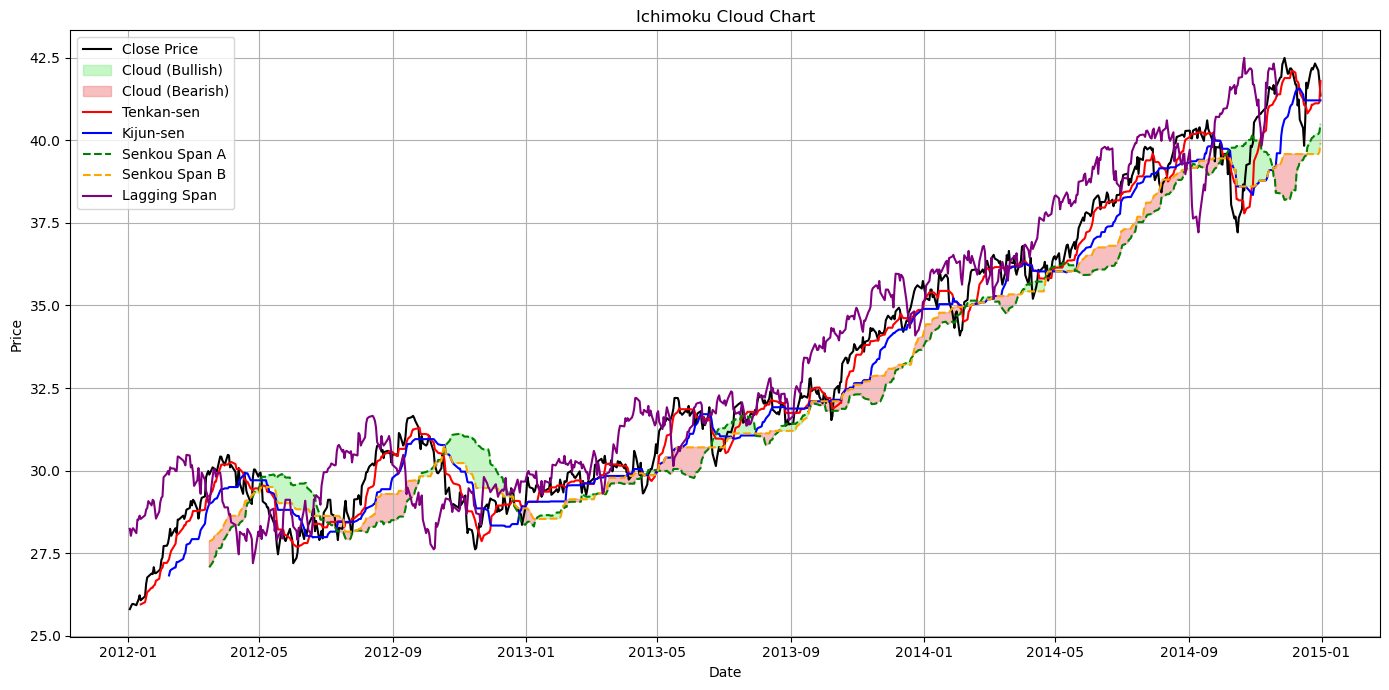

In [20]:
ichimoku_cloud(sector_etf_data['expansion']['XLK'])